In [1]:
%load_ext autoreload
%pylab inline

sys.path.insert(0, '..')

import pandas as pd
import xarray as xr
import seaborn
seaborn.set_palette('tab20')

from warnings import filterwarnings
filterwarnings('ignore', category=RuntimeWarning)

from scripts.data import main as data
from scripts import plotting as plot
from scripts import analysis

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Import data using YAML file

Note that this should work on any machine as long as you have the requirements installed. Files will be downloaded to the 

In [33]:
cat = data.read_catalog('../scripts/data/reccap2_data.yml')

In [35]:
# read SOCAT data from the website
socat = data.socat2020(cat['socat_pco2'], verbose=False)
# liar = data.soccom_float_liar(cat['soccom_liar'], verbose=False)

# reads mask data from the RECCAP website
mask = data.southern_ocean_mask()
subs = mask.subregions

# read reccap data from the FTP site
surface_co2 = data.reccap_surface_CO2(cat['surface_co2'], verbose=True, use_cache=True)
# CSIR and NIES have their fluxes -ve downward, change to +ve
for product in ['CSIR', 'NIES']:
    for key in ['fgco2', 'fgco2_glob', 'fgco2_reg']:
        if hasattr(surface_co2[key], product):
            surface_co2[key][product] = -surface_co2[key][product].load()

2021-03-31 00:46:57 [DOWNLOAD]  ================================================================================


2021-03-31 00:46:57 [DOWNLOAD]  Start of logging session
2021-03-31 00:46:57 [DOWNLOAD]  --------------------------------------------------------------------------------
2021-03-31 00:46:57 [DOWNLOAD]  Fetched 15 files from flist cache: ../data/raw/Surface_CO2/info_filelist.cache
2021-03-31 00:46:57 [DOWNLOAD]  RECCAP2 SURFACE OCEAN PCO2 DATA PRODUCTS  15 files ftp://ftp.bgc-jena.mpg.de/pub/outgoing/RECCAP2/32yTa68UrnNxJ6VYndOI/Ocean/Surface_CO2/*
2021-03-31 00:46:57 [DOWNLOAD]  15 files exist for ftp://ftp.bgc-jena.mpg.de/pub/outgoing/RECCAP2/32yTa68UrnNxJ6VYndOI/Ocean/Surface_CO2/*
2021-03-31 00:46:57 [DOWNLOAD]  Files will be saved to ../data/raw/Surface_CO2/
2021-03-31 00:46:57 [DOWNLOAD]  retrieving ftp://ftp.bgc-jena.mpg.de/pub/outgoing/RECCAP2/32yTa68UrnNxJ6VYndOI/Ocean/Surface_CO2/CMEMSLSCEFFNNv20210223.zip
2021-03-31 00:46:57 [DOWNLOAD]  retrieving ftp://ftp.bgc-j

# Calculate fluxes for each region

In [36]:
flux = surface_co2.fgco2.data()
area = flux.area()

In [9]:
flux_regions = []
for r in range(1, 10):
    rf = flux.where(subs == r)
    # fluxes are in mol/m2/s -- > PgC yr                        s/day . day/yr . g/mol . P
    flux_regions += (-rf * area).sum(['lat', 'lon']).compute() * 86400 * 365 * 12.011 * 1e-15,

# Plot fluxes for each region

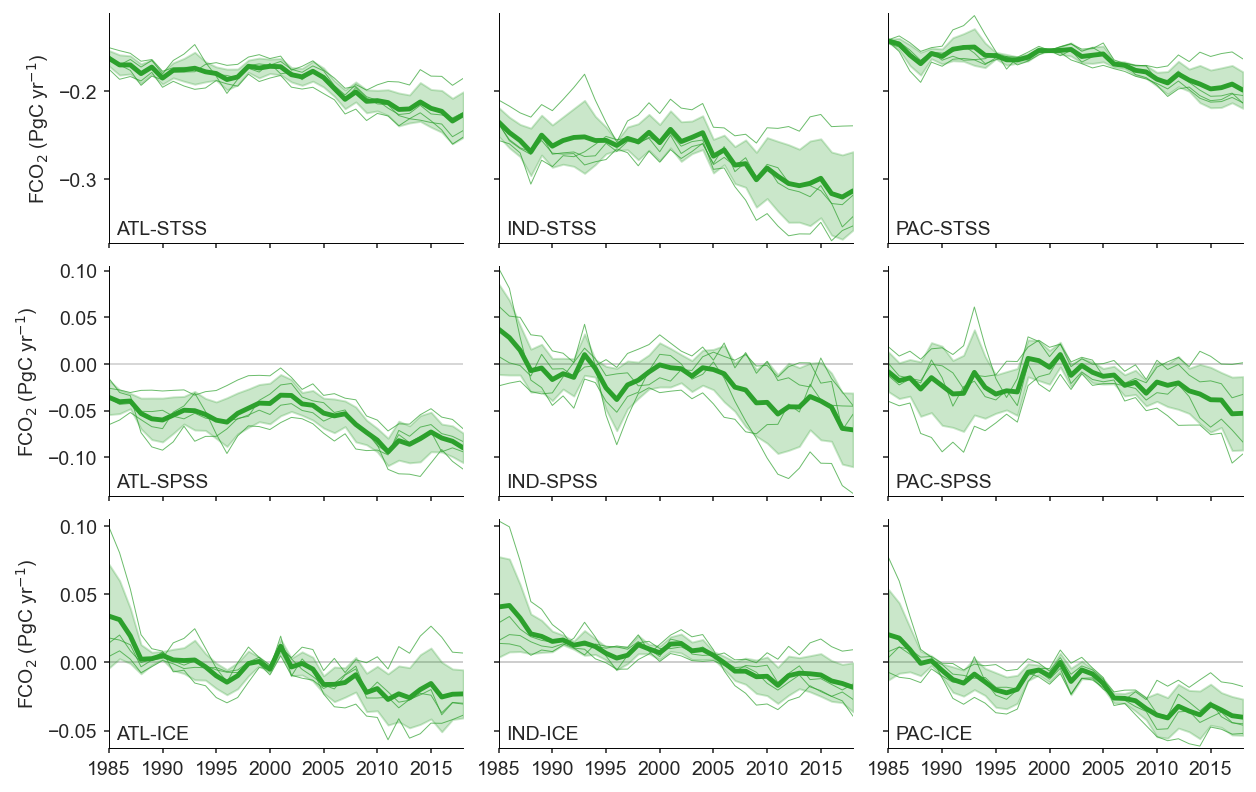

In [31]:
fig, ax = plt.subplots(3, 3, figsize=[9, 6], dpi=140, sharex='all', sharey='row')
# first transpose to draw plots columnwise
ax = ax.T.reshape(-1) 

for i, df in enumerate(flux_regions):    
    # resample the data to annual - could also smooth data instead
    df = df.resample(time='1AS').mean()
    
    # plot using premade function. Takes an ensemble and will plot the
    # ensemble members, mean of ensemble, stdev of ensemble (optional)
    plot.plot_ensemble(df, ax=ax[i], name='Data Products', color='C2')
    
    # add a label of the data on the bottom left of each ax
    name = mask.names.isel(idx=i).values
    ax[i].text(0.02, 0.02, name, va='bottom', ha='left', transform=ax[i].transAxes)

# conform plots to style. 
# draws y=0 line if in within plot range
# sets xticks to every 5 years
[plot.style_line_subplot(a, xlim=a.get_xlim()) for a in ax]
# only left subplot labels
[a.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)') for a in ax[:3]]

plt.show()